# Football Manager 2024 - Player Valuation Analysis

An attempt to model player valuation based on their attributes to find undervalued attributes.

### Data Loading

In [2]:
import pandas as pd
import numpy as np
import datetime as dt

file = "Export 10K players.rtf"
df = pd.read_csv(file, delimiter="|")

### Data Pre-Processing

In [3]:
df = df.rename(columns=str.strip) #stripping column names
df.dropna(subset=["Height"], inplace=True)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Strip spaces, and convert wage to a float
df["Wage"] = df["Wage"].str.strip()
df["Wage"] = df["Wage"].str.replace("£", "", regex=True)
df["Wage"] = df["Wage"].str.replace(",", "", regex=True)
df["Wage"] = df["Wage"].str.replace(" p/w", "", regex=True)
df["Wage"] = df["Wage"].astype(float)

# Handling the string for transfer value and creating an average float value between min and max estimate.
df[["Min Value", "Max Value"]] = df["Transfer Value"].str.split(" - ", expand=True)
df["Min Value"] = df["Min Value"].str.strip().str.replace("£", "")
df["Min Value"] = df["Min Value"].replace("Not for Sale", np.nan)
df["Max Value"] = df["Max Value"].str.strip().str.replace("£", "")

def convert_values(value):
    if pd.isna(value):
        return np.nan
    elif "M" in value:
        return float(value.replace("M", "")) * 1000000
    elif "K" in value:
        return float(value.replace("K", "")) * 1000
    else:
        return float(value)
    
df["Min Value"] = df["Min Value"].apply(convert_values)
df["Max Value"] = df["Max Value"].apply(convert_values)
df["Avg Value"] = (df["Min Value"] + df["Max Value"]) / 2

# Converting the height data into cm
df[["height_feet", "height_inch"]]= pd.DataFrame(df["Height"].str.strip().str.replace('"', "").str.split("'").to_list(), index=df.index).astype(int)
df["height_cm"] = (((df["height_feet"] * 12) + (df["height_inch"])) * 2.54).astype(float)


# Converting the contract expiry date into years remaining
start_date = dt.datetime.strptime('2023-09-01', "%Y-%m-%d")
df["Expires"] = pd.to_datetime(df["Expires"], dayfirst=True)
df["Months Remaining"] = round(((df["Expires"] - start_date).dt.days / 30.4375),0)


# Drop any rows will nulls.
df = df.dropna()


# Outputting the cleansed data to csv for checking
df.to_csv("output.csv")

### Exploratory Data Analysis

count    1.055400e+04
mean     5.878477e+06
std      1.523408e+07
min      2.000000e+05
25%      6.600000e+05
50%      1.325000e+06
75%      4.400000e+06
max      2.235000e+08
Name: Avg Value, dtype: float64


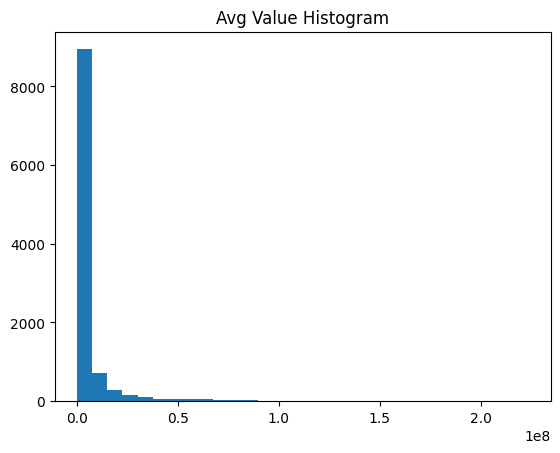

In [4]:
import matplotlib.pyplot as plt

print(df["Avg Value"].describe())

plt.hist(df["Avg Value"], bins=30)
plt.title("Avg Value Histogram")
plt.show()

As you can see, the target variable is heavily right skewed. Therefore, I will apply a log transformation.

count    10554.000000
mean        14.403762
std          1.368437
min         12.206078
25%         13.399997
50%         14.096924
75%         15.297115
max         19.224922
Name: Log Avg Value, dtype: float64


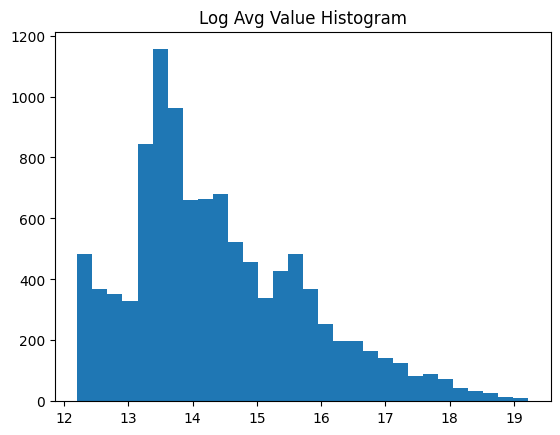

In [5]:
df["Log Avg Value"] = np.log1p(df["Avg Value"])
print(df["Log Avg Value"].describe())
plt.hist(df["Log Avg Value"], bins=30)
plt.title("Log Avg Value Histogram")
plt.show()

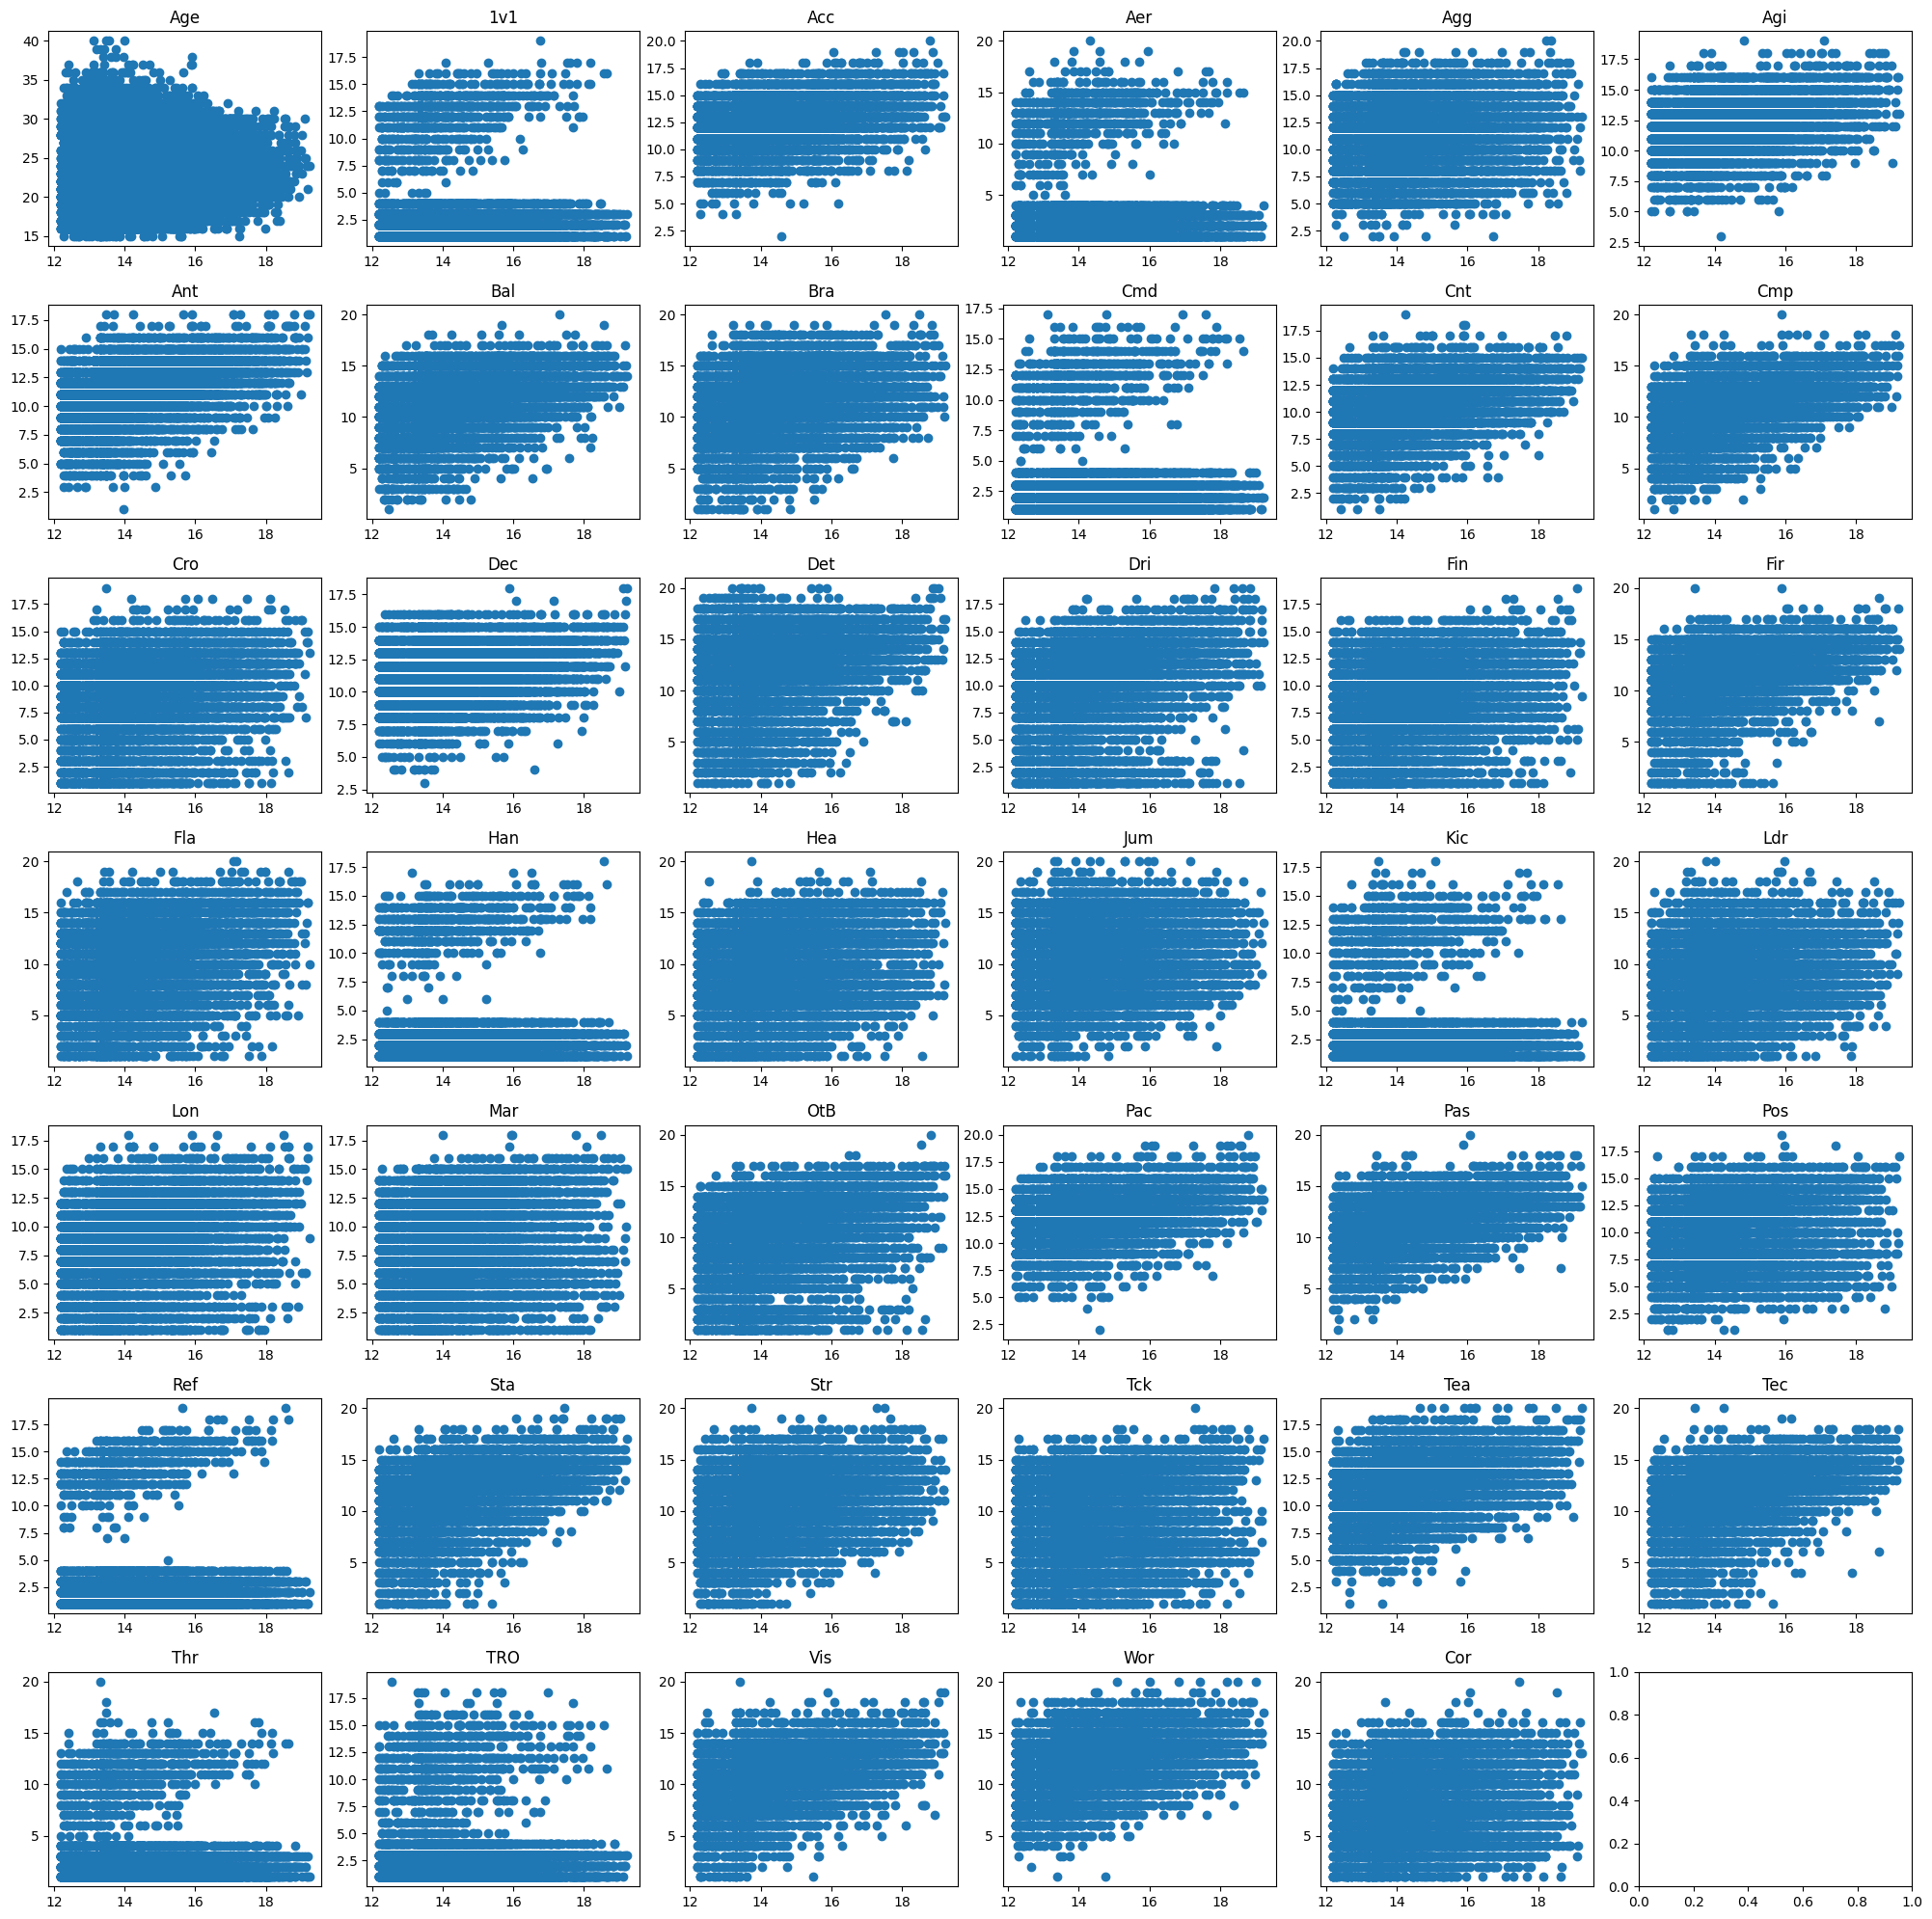

In [6]:
n_rows, n_cols = 7, 6

columns = ["Age", "1v1", "Acc", "Aer", "Agg", "Agi", "Ant", "Bal", "Bra", "Cmd", "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla", "Han", "Hea", "Jum", "Kic", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Ref", "Sta", "Str", "Tck", "Tea", "Tec", "Thr", "TRO", "Vis",
               "Wor", "Cor"]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,20))
axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].scatter(df["Log Avg Value"], df[col])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

As you can see from above, a clear insight to take from this is that the GK attributes are messing up everying else. The decision here should be to separate the model into a GK and an outfield model.

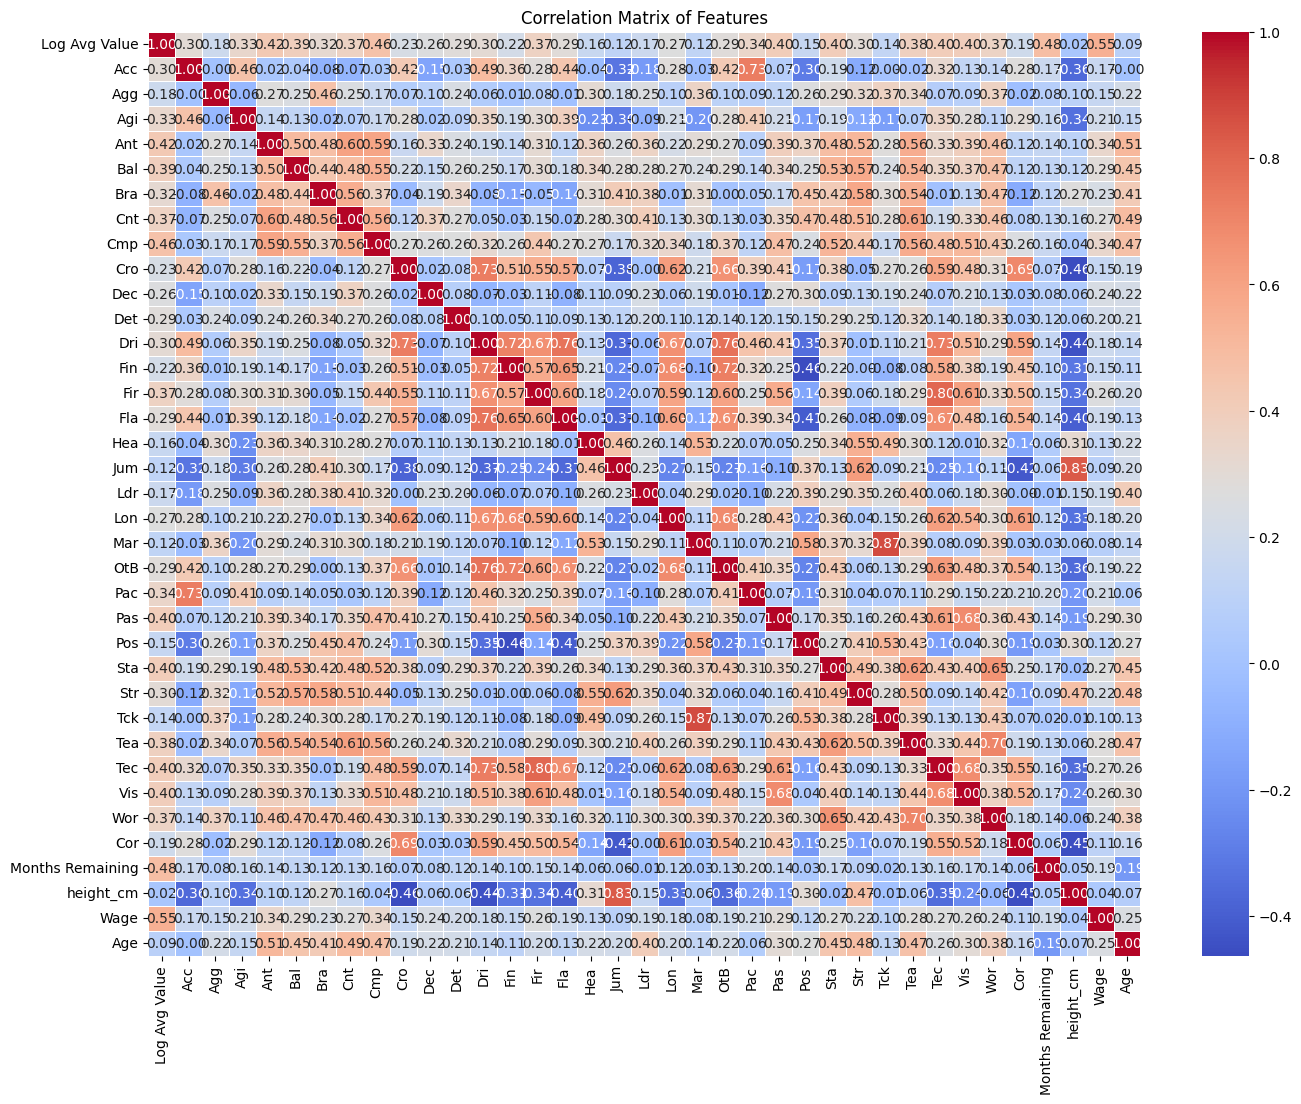

In [7]:
import seaborn as sns

corr_matrix = df[["Log Avg Value", "Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age"]].corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of Features")
plt.show()

I wouldn't say there are any bib issues with the correlation matrix, however one insight is that some features could be merged, particularly the features that have a corr score of > 0.8.

### Feature Engineering

In [8]:
# Merging attributes into features that represent training groups.

df["Aerial ability"] = (df["height_cm"] + df["Jum"]).mean()
df["Defensive Ability"] = (df["Tck"] + df["Mar"]).mean()


Next I am going to build in some categorical variables, such as league and nationality. 

As to not have lots of features produced from one-hot enconding. I am going to create a feature called "Top 5 League" and it will be a binary 1 or 0 for whether the player plays in a top 5 league.

I am also going to do something similar with player nationality. Using this study https://football-observatory.com/IMG/sites/mr/mr55/en/ to make up the top 10 (although I am going to swap Serbia and Portugal as I think that intuitively makes more sense, probably being biased here)

In [9]:
# Binary variable to capture top 5 league effect.
top_5_leagues = ["English Premier Division", "Ligue 1 Uber Eats", "Spanish First Division", "Bundesliga", "Italian Serie A"]
df["Division"] = df["Division"].str.strip()
df["top_5_league"] = df["Division"].isin(top_5_leagues).astype(int)



# English Tax
nationalities = ["ENG"]
df["Nat"] = df["Nat"].str.strip()
df["top_10_nations"] = df["Nat"].isin(nationalities).astype(int)




In [10]:
from sklearn.preprocessing import StandardScaler


# Currently I am filtering out GK players and GK attributes from the model.
df = df[~df["Position"].str.contains("GK")]
X_outfield = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "top_5_league", "top_10_nations"]]

X_outfield_dummies = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Jum", "Ldr", "Lon", "Mar",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tck", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Months Remaining", "height_cm", "Wage", "Age", "Nat", "Division"]]

X_outfield_dummies = pd.get_dummies(X_outfield_dummies, columns=["Nat", "Division"], drop_first=True)

X_outfield_merged = df[["Acc", "Agg", "Agi", "Ant", "Bal", "Bra",  "Cnt", "Cmp", "Cro",
               "Dec", "Det", "Dri", "Fin", "Fir", "Fla",  "Hea", "Ldr", "Lon",
               "OtB", "Pac", "Pas", "Pos", "Sta", "Str", "Tea", "Tec",  "Vis",
               "Wor", "Cor", "Aerial ability", "Defensive Ability",  "Months Remaining", "Wage", "Age", "top_5_league", "top_10_nations"]]





### Model Building

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Testing the model for all attribute features

y = df["Log Avg Value"]
scaler = StandardScaler()
X_outfield_scaled = scaler.fit_transform(X_outfield)

X_train, X_test, y_train, y_test = train_test_split(X_outfield_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print(f"r2: {r2}")
print(f"mse: {mse}")

r2: 0.6895024743948017
mse: 0.589278355076227


I will now do some cross-validation testing on the model with the un-merged features.

In [12]:
y = df["Log Avg Value"]
scaler = StandardScaler()
X_outfield_scaled = scaler.fit_transform(X_outfield)

X_train, X_temp, y_train, y_temp = train_test_split(X_outfield_scaled, y, test_size=0.4, random_state=42)
X_test, X_cv, y_test, y_cv = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_cv = model.predict(X_cv)

mse_train = mean_squared_error(y_train, y_pred_train)
mse_cv = mean_squared_error(y_cv, y_pred_cv)

r2_train = r2_score(y_train, y_pred_train)
r2_cv = r2_score(y_cv, y_pred_cv)

print(f"Training Error (MSE): {mse_train}")
print(f"CV Error (MSE): {mse_cv}")

Training Error (MSE): 0.5921724907831255
CV Error (MSE): 0.5944263968794046


The above shows that the model is displaying relatively low variance with a small gap between the training error and the CV error.

I am now going to test out a lasso and a ridge model to test whether adding regularization to the model will improve it's metrics.

In [13]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=100)
ridge.fit(X_train, y_train)
ridge_y_train_pred = ridge.predict(X_train)
ridge_train_mse = mean_squared_error(y_train, ridge_y_train_pred)
ridge_y_cv_pred = ridge.predict(X_cv)
ridge_cv_mse = mean_squared_error(y_cv, ridge_y_cv_pred)
ridge_r2_train = r2_score(y_train, ridge_y_train_pred)
ridge_r2_cv = r2_score(y_cv, ridge_y_cv_pred)

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
lasso_y_train_pred = lasso.predict(X_train)
lasso_train_mse = mean_squared_error(y_train, lasso_y_train_pred)
lasso_y_cv_pred = lasso.predict(X_cv)
lasso_cv_mse = mean_squared_error(y_cv, lasso_y_cv_pred)

print(f"Training Set: Standard model: {mse_train} | Ridge Model: {ridge_train_mse} + R2: {ridge_r2_train} | Lasso Model: {lasso_train_mse}")
print(f"CV Set: Standard model: {mse_cv} | Ridge Model: {ridge_cv_mse} + R2: {ridge_r2_cv}| Lasso Model: {lasso_cv_mse}")

Training Set: Standard model: 0.5921724907831255 | Ridge Model: 0.592386044748013 + R2: 0.684877096911608 | Lasso Model: 0.592223600153885
CV Set: Standard model: 0.5944263968794046 | Ridge Model: 0.5928921320456599 + R2: 0.6856303717020377| Lasso Model: 0.5944051611663637


In [14]:
# Re-evaluating MSE after log transformation

ridge_y_train_pred_unlog = np.exp(ridge_y_train_pred)
ridge_y_cv_pred_unlog = np.exp(ridge_y_cv_pred)

y_train_unlog = np.exp(y_train)
y_cv_unlog = np.exp(y_cv)

train_mse_original = mean_squared_error(y_train_unlog, ridge_y_train_pred_unlog)
cv_mse_original = mean_squared_error(y_cv_unlog, ridge_y_cv_pred_unlog)

print(f"Train Origingal MSE: {train_mse_original}")
print(f"CV Origingal MSE: {cv_mse_original}")



Train Origingal MSE: 1.1544303113160268e+16
CV Origingal MSE: 5.484191741208681e+19


The output from the above step suggests that normalisation is not needed. The MSEs from the Lasso and Ridge Model (after experimenting with values of alpha) converge on an almost indentical value to the standard models MSE

### Model Output Analysis

In [15]:
coefficients = model.coef_

coef_df = pd.DataFrame({
    "Feature": X_outfield.columns,
    "Coefficient": coefficients
})

coef_df.sort_values("Coefficient", ascending=False, inplace=True)

print(coef_df)

             Feature  Coefficient
34              Wage     0.320835
32  Months Remaining     0.229773
0                Acc     0.189716
36      top_5_league     0.172487
9                Dec     0.162910
28               Tec     0.124877
2                Agi     0.109261
21               Pac     0.108589
25               Str     0.104949
37    top_10_nations     0.104485
14               Fla     0.102223
7                Cmp     0.096985
16               Jum     0.095063
15               Hea     0.088836
19               Mar     0.086304
13               Fir     0.076534
24               Sta     0.070672
4                Bal     0.066589
12               Fin     0.064669
3                Ant     0.064540
10               Det     0.063646
5                Bra     0.059053
30               Wor     0.056561
17               Ldr     0.055152
26               Tck     0.042410
22               Pas     0.040208
18               Lon     0.039800
6                Cnt     0.037979
11            